# EE123 Final Project Part I: JPEG123 Compression

### Written by Alan Dong, Gautam Gunjala, and Miki Lustig, Spring 2020
<br>
<div style="text-align: right"><i> "Do I look like I know what a JAY PEG is? I just want a picture of a got dang hot dog!" - Hank Hill </i></div>

In [1]:
# Install packages
!pip install bidict

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple


In [2]:
# Import functions and libraries
import numpy as np
import scipy.fftpack
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from bitarray import bitarray
from huffman import *
from os import stat
from PIL import Image
%matplotlib inline

JPEG is an extremely popular image compression format for natural images. It has been used for over 30 years and is quite simple to implement. While there are several variations to the JPEG file format and how things are stored, the basic idea is the following: 
* The color representation of RGB is converted to luminance and chrominance components (called YCbCr) through a color transformation
* The color, or chrominance, components are downsampled
* The image is broken into 8x8 blocks. Each block goes through the following: 
 * The discrete cosine transform (DCT) is applied
 * The DCT coefficients are quantized, resulting in many small values and zeros
 * The quantized coefficients are zigzag ordered
 * Run-length encoding is applied, followed by Huffman coding

That's it!

In this lab, we will implement all of these, and create a file that, although not exactly compatible with the JPEG format, results in a very good quality compression.

First, let's start with image loading and image manipulation. We will use the PIL library. We will load an uncompressed image first. 

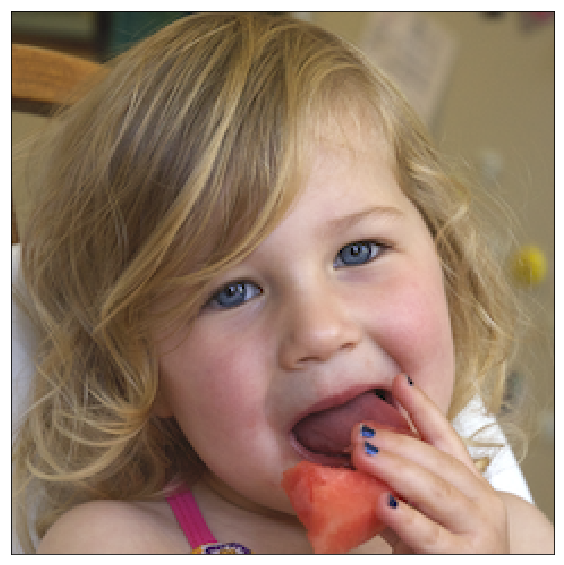

In [3]:
# Load TIFF image
img = Image.open("NetaLi_small.tiff")
img = np.array(img)[:,:,0:3]
M, N = img.shape[0:2]

# Display image
plt.figure(figsize=(10,10))
plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

### Task I: Color representation conversion

A number of distinct representations of color exist for various applications. For example, most color cameras acquire image data in RGB (red, green, blue) format as intensity through red, green, and blue absorption filters arranged in a Bayer pattern. Other common color representations include HSV (hue, saturation, value) and CMYK (cyan, magenta, yellow, black). Each color representation is associated with a gamut, or range of representable colors, which can vary. In general, transformation from one representation to another is neither trivial nor always possible.

We will assume that we begin with image data in RGB format. Since there are three separate color channels, a naive approach would be to treat one color image as three distinct monochromatic images and apply the same processing to each. However, this format is quite redundant since each color channel contains a nearly identical image. This redundancy motivates the need for a different representation of color for image compression. The format used in JPEG is known as YCbCr, which represents luma (Y), and chroma (Cb, Cr), and is related to the RGB format by a simple affine transformation.  
<br>
$$ \left[ \begin{array}{c} Y \\ C_b \\ C_r \end{array}\right] = \left[ \begin{array}{c} -128 \\ 0 \\ 0 \end{array}\right] + \left[ \begin{array}{ccc} 0.299 & 0.587 & 0.114 \\ -0.168736 & -0.331264 & 0.5 \\ 0.5 & -0.418688 & -0.081312 \end{array}\right] \left[ \begin{array}{c} R \\ G \\ B \end{array}\right]$$
<br>

As you can see from the equation, Y is a weighted sum of R, G, and B, so it represents something like brightness. You may notice that green gets the largest weight and blue gets the smallest weight. This is related to the relative abundance of color sensing cone cells in the retina. Cb is the difference between B and a combination of R and G, so it represents a 1D color spectrum between blue and yellow. Cr is approximately the difference between R and G, so it represents a 1D color spectrum between red and green. These color differences are related to the color opponent cells in the primary visual area (V1) of the cerebral cortex.
 
**Note: While RGB and YCbCr values are typically integers in range [0,255], we will keep our RGB values as floats in range [0.0,255.0] and our YCbCr values as floats in range [-128.0,127.0] to avoid rounding errors and reduce DC energy. We will only cast to integer type when necessary.**

Write a function `im_ycbcr = RGB2YCbCr(im_rgb)`, which takes a 3D numpy float array, representing an RGB image and returns a 3D numpy float array, representing Y, Cb, and Cr components.

Write a function `im_rgb = YCbCr(im_ycbcr)`, which does the reverse. Make sure on the reverse that the RGB values are bounded between 0.0 and 255.0 by clipping the values.

In [36]:
con = np.array([-128,0,0])
scl = np.array([[0.299,0.587,0.114],[-0.168736,-0.331264,0.5],[0.5,-0.418688,-0.081312]])
def RGB2YCbCr(im_rgb):
    # Input:  a 3D float array, im_rgb, representing an RGB image in range [0.0,255.0]
    # Output: a 3D float array, im_ycbcr, representing a YCbCr image in range [-128.0,127.0]
    
    # Your code here
    im_ycbcr = np.zeros(im_rgb.shape)
    for r in range(im_rgb.shape[0]):
        for c in range(im_rgb.shape[1]):
            ycbcr = con+scl.dot(im_rgb[r][c])
            for i in range(ycbcr.shape[0]):
                ycbcr[i] = clip(ycbcr[i],-128.0,127.0)
            im_ycbcr[r][c] = ycbcr
    return im_ycbcr

def YCbCr2RGB(im_ycbcr):
    # Input:  a 3D float array, im_ycbcr, representing a YCbCr image in range [-128.0,127.0]
    # Output: a 3D float array, im_rgb, representing an RGB image in range [0.0,255.0]
    
    # Your code here
    im_rgb = np.zeros(im_ycbcr.shape)
    for r in range(im_ycbcr.shape[0]):
        for c in range(im_ycbcr.shape[1]):
            rgb = np.linalg.inv(scl).dot(im_ycbcr[r][c] - con)
            for i in range(rgb.shape[0]):
                rgb[i] = clip(rgb[i],0.0,255.0)
            im_rgb[r][c] = rgb
    return im_rgb

def clip(num,low,high):
    return low if num < low else (high if num > high else num)

We now extract the RGB components from the original image and convert them to YCbCr using the functions you defined above. 

In [37]:
img_ycbcr = RGB2YCbCr(img)

Display each channel in the RGB image separately, by zero-ing the other components. For example, to display red, you will need to zero out the green and blue channels.

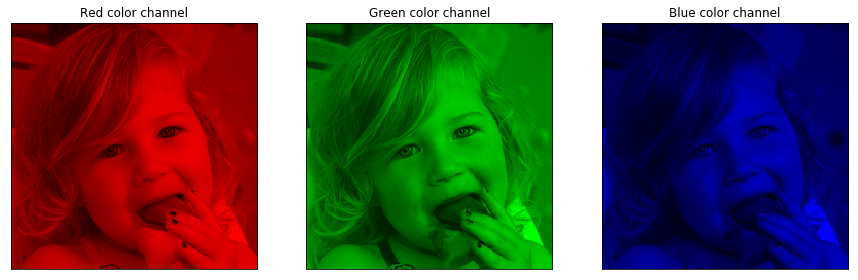

In [26]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
R_only = img.copy()
R_only[:,:,[1,2]] = 0.
plt.imshow(R_only), plt.xticks([]), plt.yticks([])
plt.title('Red color channel')

plt.subplot(1,3,2)
G_only = img.copy()
G_only[:,:,[0,2]] = 0.
plt.imshow(G_only), plt.xticks([]), plt.yticks([])
plt.title('Green color channel')

plt.subplot(1,3,3)
B_only = img.copy()
B_only[:,:,[0,1]] = 0.
plt.imshow(B_only), plt.xticks([]), plt.yticks([])
plt.title('Blue color channel')

plt.show()

In order to display the information in the YCbCr channels, we will only keep one component at a time, and convert it back to RGB to be able to display its contribution.  

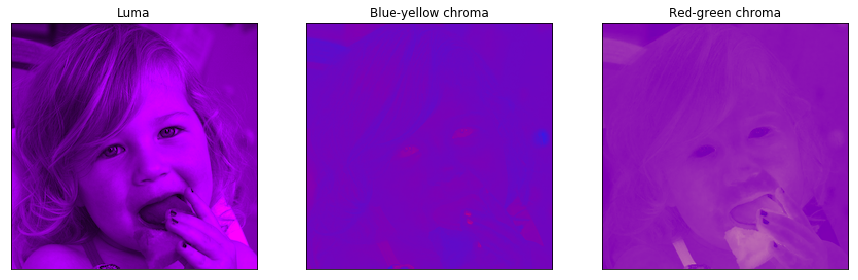

In [30]:
plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
tmp = img_ycbcr.copy()
tmp[:,:,[1,2]] = 0.
Y_only = YCbCr2RGB(tmp).astype(np.uint8)
plt.imshow(Y_only), plt.xticks([]), plt.yticks([])
plt.title('Luma')

plt.subplot(1,3,2)
tmp = img_ycbcr.copy()
tmp[:,:,[0,2]] = 0.
Cb_only = YCbCr2RGB(tmp).astype(np.uint8)
plt.imshow(Cb_only), plt.xticks([]), plt.yticks([])
plt.title('Blue-yellow chroma')

plt.subplot(1,3,3)
tmp = img_ycbcr.copy()
tmp[:,:,[0,1]] = 0.
Cr_only = YCbCr2RGB(tmp).astype(np.uint8)
plt.imshow(Cr_only), plt.xticks([]), plt.yticks([])
plt.title('Red-green chroma')

plt.show()

One step that is commonly performed in JPEG is to downsample the Cb and Cr arrays by a factor of two in both dimensions. We will avoid aliasing by using a 2D bilinear filter followed by decimation.

Write functions to downsample and upsample the Cb and Cr components using Image.resize and bilinear interpolation with:

`numpy.array(Image.fromarray(arr).resize((width, height), resample=Image.BILINEAR))`

**WARNING:** PIL uses (width, height) to represent image size instead of the usual numpy array shape of (M, N) where M is height and N is width. DO NOT MAKE THIS MISTAKE.

In [33]:
def chroma_downsample(C):
    # Input:  an MxN array, C, of chroma values
    # Output: an (M/2)x(N/2) array, C2, of downsampled chroma values
    
    # Your code here
    C2 = np.array(Image.fromarray(C).resize((C.shape[1]//2, C.shape[0]//2), resample=Image.BILINEAR))
    return C2

def chroma_upsample(C2):
    # Input:  an (M/2)x(N/2) array, C2, of downsampled chroma values
    # Output: an MxN array, C, of chroma values
    
    # Your code here
    C = np.array(Image.fromarray(C2).resize((C2.shape[1]*2, C2.shape[0]*2), resample=Image.BILINEAR))
    return C

In [34]:
Y = img_ycbcr[:,:,0]
Cb = img_ycbcr[:,:,1]
Cr = img_ycbcr[:,:,2]

Cb2 = chroma_downsample(Cb)
Cr2 = chroma_downsample(Cr)

Reconstruct back the RGB by upsampling the chroma components, and convert back to RGB from YCbCr. Display the difference amplified by 10. 

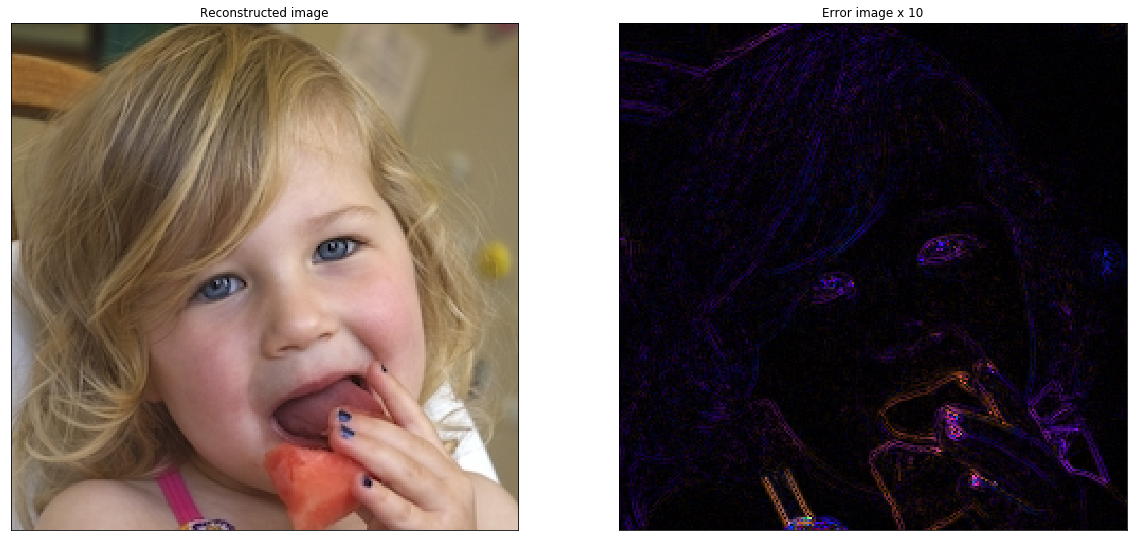

In [38]:
Cb_rec = chroma_upsample(Cb2)
Cr_rec = chroma_upsample(Cr2)

img_rec = YCbCr2RGB(np.stack((Y,Cb_rec,Cr_rec), axis=-1))

# Plots
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img_rec.astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title('Reconstructed image')
plt.subplot(1,2,2)
plt.imshow(abs((img_rec-img)*10).astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title('Error image x 10')
plt.show()

**Question:** Based on your plots of the various components of the image, why might it be appropriate to downsample the Cb and Cr component arrays?

**Answer:** Human eyes notice brightness variation more than color variation, so downsampling Cb and Cr allow for little noticable visual difference while also allowing more compression.

### Task II: Discrete cosine transform

Rather than storing pixel values as they occur in the image, we would like to convert the image to a representation in which only a few coefficients are necessary. We have seen this idea in class as the motivation for wavelets and the discrete wavelet transform. A number of options exist, some of which you may want to explore in your final projects. In this lab, we will use the **type-II discrete cosine transform (DCT-II)**, which is used by the JPEG image format.

The DCT is similar to the discrete Fourier transform (DFT), but with a few key differences. The basis elements on which a function is projected is now a set of cosine functions at various frequencies instead of complex exponentials. Note that when working with images, we have *spatial* frequencies, rather than *temporal* frequencies. This change of basis implies that: (1) DCT coefficients are always real (images are assumed to be real-valued signals), and (2) the boundary conditions are symmetric rather than periodic. These differences enable a greater degree of "energy compactness" in the transform coefficients. The formula for the one-dimensional DCT-II is given below.  
<br>
$$ X_{DCT-II}[k] = \sum\limits_{n=0}^{N-1} x[n] \cos \left[ \frac{\pi}{N} \left( n + \frac{1}{2} \right) k \right], ~~~~~k = 0,1,...,N-1 $$
<br>

To implement a two-dimensional transform, we apply a one-dimensional transform on the rows of the image followed by a one-dimensional transform on the columns. The 2D-DCT is performed block-wise on 8x8 pixel blocks of each of the Y, Cb, and Cr image components. In the following cell, implement the forward 2D DCT (and inverse). Apply it to an 8x8 block of the Y component of the original image.

For computing the DCT, we will use `scipy.fftpack.dct`, with the `norm='ortho'` argument. 

In [39]:
def dct2(block):
    # Input:  a 2D array, block, representing an image block
    # Output: a 2D array, block_c, of DCT coefficients
    
    # Your code here
    block_c = scipy.fftpack.dct(block, axis=1, norm='ortho')
    block_c = scipy.fftpack.dct(block_c, axis=0, norm='ortho')
                
    return block_c

def idct2(block_c):
    # Input:  a 2D array, block_c, of DCT coefficients
    # Output: a 2D array, block, representing an image block
    
    # Your code here
    block = scipy.fftpack.idct(block_c, axis=1, norm='ortho')
    block = scipy.fftpack.idct(block, axis=0, norm='ortho')
    
    return block

Pick an 8x8 block just above the left eye in the Y image (`Y[112:120,112:120]`). Display the block. Then, compute and display the absolute value of the DCT coefficients. Scale the value of white to the largest DCT coefficient, and the value of black to zero. 

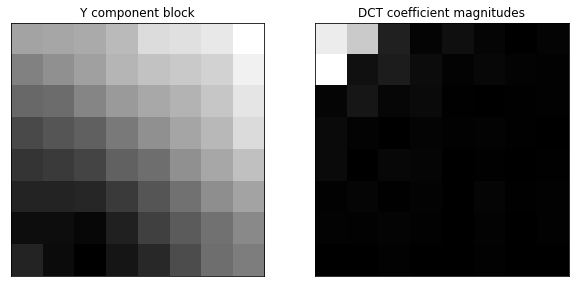

In [40]:
block = Y[112:120,112:120]

block_c = dct2(block)

# Plots
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(block, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Y component block')
plt.subplot(1,2,2)
plt.imshow(abs(block_c), cmap='gray', vmin=0, vmax=np.max(abs(block_c))), plt.xticks([]), plt.yticks([])
plt.title('DCT coefficient magnitudes')
plt.show()

**Question:** Comment on the distribution of DCT coefficients, as compared to the image pixels.

**Answer:** The DCT coefficients are more sparse than the Y image, with majority of the energy/white pixels in the top left and the remaining pixels black. In contrast, the Y image has kind of a gradient from black to white.

### Task III: DCT coefficient quantization

The DCT coefficients are at this point arbitrary real numbers (stored as floating points). We have previously seen the idea of thresholding coefficients close to zero for compression. This idea can be generalized to nonzero coefficients as well and is known as **quantization**. By using representative values for *intervals* of floating point numbers, we increase redundancy in our image representation, thereby improving our ability to compress the image. We also reduce the number of bits required to store each value. This is achieved using **element-wise  integer division** with a so-called quantization matrix. Values in standard quantization matrix are empirically determined and tuned based on our ability to percieve their corresponding spatial frequencies in an image. The standard quantization matrix is then scaled by a number that depends on the JPEG "quality factor", an integer in the range [1,100], to get the final quantization matrix. Higher quality factor implies smaller divisors and thus, smaller intervals being mapped to the same quantized value.

When "inverting" the compression steps, the quantized DCT coefficients are multiplied by the quantization matrix (don't forget the quality factor) to obtain an approximation of the original DCT coefficients. **Note: These will NOT be the same as before quantization occurred. Remember that JPEG is a lossy format.**

The following are standard quantization matrices used in JPEG compression. Note that a different matrix is applied to the luma ($Q_Y$) and chroma ($Q_C$) components of the image.
<br>
$$ Q_{Y} = \left[ \begin{array}{cccccccc} 
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 \\
12 & 12 & 14 & 19 & 26 & 58 & 60 & 55 \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 \\
24 & 36 & 55 & 64 & 81 & 104 & 113 & 92 \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101 \\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99 \end{array} \right], ~~~~~ 
Q_{C} = \left[ \begin{array}{cccccccc}
17 & 18 & 24 & 47 & 99 & 99 & 99 & 99 \\
18 & 21 & 26 & 66 & 99 & 99 & 99 & 99 \\
24 & 26 & 56 & 99 & 99 & 99 & 99 & 99 \\
47 & 66 & 99 & 99 & 99 & 99 & 99 & 99 \\
99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \\
99 & 99 & 99 & 99 & 99 & 99 & 99 & 99 \end{array} \right]
$$  
<br>



**Question:** Comment on the positions of large and small values within the quantization matrices and how this relates to the quantization noise spectrum. Why are some frequencies of quantization noise less bad than others?

**Answer:** In both matrices, smaller values are closer to the top left and larger to the bottom right. In $Q_Y$ the values gradually grow larger as you move right and down, but in $Q_C$ there are only a few small values in the top left corner before it suddenly jumps to large values. Since quantization involves dividing, low frequencies (top left) are left mostly intact while high frequencies (bottom right) are significantly reduced. Higher frequencies are "more bad" than others because human eyes cannot distinguish higher frequencies as well.

In the following block, write a function that quantizes an array of DCT coefficients using the matrices defined above and a given quality factor. Write another function that "inverts" this operation. Pay close attention to data types and make sure to *round your floats* before casting them as ints using `np.round()`.

In [109]:
def quantize(block_c, mode="y", quality=75):
    # Input:  a 2D float array, block_c, of DCT coefficients
    #         a string, mode, ("y" for luma quantization, "c" for chroma quantization)
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Output: a 2D int array, block_cq, of quantized DCT coefficients
    
    if mode is "y":
        Q = np.array([[ 16,  11,  10,  16,  24,  40,  51,  61 ],
                      [ 12,  12,  14,  19,  26,  58,  60,  55 ],
                      [ 14,  13,  16,  24,  40,  57,  69,  56 ],
                      [ 14,  17,  22,  29,  51,  87,  80,  62 ],
                      [ 18,  22,  37,  56,  68,  109, 103, 77 ],
                      [ 24,  36,  55,  64,  81,  104, 113, 92 ],
                      [ 49,  64,  78,  87,  103, 121, 120, 101],
                      [ 72,  92,  95,  98,  112, 100, 103, 99 ]])
    elif mode is "c":
        Q = np.array([[ 17,  18,  24,  47,  99,  99,  99,  99 ],
                      [ 18,  21,  26,  66,  99,  99,  99,  99 ],
                      [ 24,  26,  56,  99,  99,  99,  99,  99 ],
                      [ 47,  66,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ]]) 
    else:
        raise Exception("String argument must be 'y' or 'c'.")
        
    if quality < 1 or quality > 100:
        raise Exception("Quality factor must be in range [1,100].")
    
    scalar = 5000 / quality if quality < 50 else 200 - 2 * quality # formula for scaling by quality factor
    Q = Q * scalar / 100. # scale the quantization matrix
    Q[Q<1.] = 1. # do not divide by numbers less than 1
    
    # Your code here
    block_cq = np.zeros(block_c.shape)
    for r in range(block_c.shape[0]):
        for c in range(block_c.shape[1]):
            block_cq[r][c] = int(np.round(block_c[r][c]/Q[r][c]))
    
    return block_cq.astype(int)

def unquantize(block_cq, mode="y", quality=75):
    # Input:  a 2D int array, block_cq, of quantized DCT coefficients
    #         a string, mode, ("y" for luma quantization, "c" for chroma quantization)
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Output: a 2D float array, block_c, of "unquantized" DCT coefficients (they will still be quantized)
    
    if mode is "y":
        Q = np.array([[ 16,  11,  10,  16,  24,  40,  51,  61 ],
                      [ 12,  12,  14,  19,  26,  58,  60,  55 ],
                      [ 14,  13,  16,  24,  40,  57,  69,  56 ],
                      [ 14,  17,  22,  29,  51,  87,  80,  62 ],
                      [ 18,  22,  37,  56,  68,  109, 103, 77 ],
                      [ 24,  36,  55,  64,  81,  104, 113, 92 ],
                      [ 49,  64,  78,  87,  103, 121, 120, 101],
                      [ 72,  92,  95,  98,  112, 100, 103, 99 ]])
    elif mode is "c":
        Q = np.array([[ 17,  18,  24,  47,  99,  99,  99,  99 ],
                      [ 18,  21,  26,  66,  99,  99,  99,  99 ],
                      [ 24,  26,  56,  99,  99,  99,  99,  99 ],
                      [ 47,  66,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ],
                      [ 99,  99,  99,  99,  99,  99,  99,  99 ]]) 
    else:
        raise Exception("String argument must be 'y' or 'c'.")
            
    if quality < 1 or quality > 100:
        raise Exception("Quality factor must be in range [1,100].")
        
    scalar = 5000 / quality if quality < 50 else 200 - 2 * quality # formula for scaling by quality factor
    Q = Q * scalar / 100. # scale the quantization matrix
    Q[Q<1.] = 1. # do not divide by numbers less than 1
    
    # Your code here
    block_c = np.zeros(np.array(block_cq).shape)
    for r in range(block_c.shape[0]):
        for c in range(block_c.shape[1]):
            block_c[r][c] = np.round(block_cq[r][c]*Q[r][c])
    
    return block_c  

Quantize the DCT block you calculated above with quality 75 (considered good quality). Then, reconstruct back the Y block and display the original and quantized one next to each other. Do you see many differences?

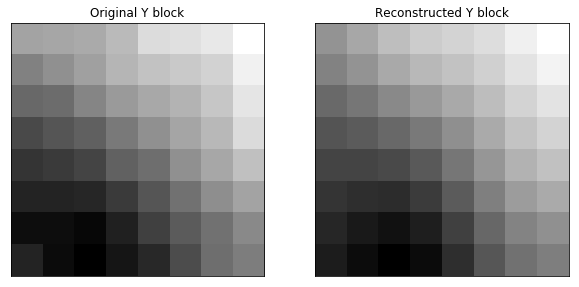

In [78]:
block_cq = quantize(block_c, "y", quality=75) # quantize the Y block DCT coefficients

block_cqu = unquantize(block_cq, "y", quality=75) # "unquantize" to approximate original DCT coefficients

block_rec = idct2(block_cqu)

# Plots
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(block, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Original Y block')
plt.subplot(1,2,2)
plt.imshow(block_rec, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title('Reconstructed Y block')
plt.show()

### Task IV: Run-length encoding

#### Zig-zag reordering

Looking at the quantized DCT coefficients, we see that the largest coefficient typically occurs in the upper left corner (DC), and that coefficients tend to shrink as we move towards the bottom right corner. We can take advantage of this trend to further compress our image representation. The first step in doing so is to convert our 2D array of coefficients into a 1D list in a way that respects the typical decrease in coefficient magnitude. We will reorder the DCT coefficients in a zig-zag pattern as shown in the following figure:

<img src="./zigzag.gif" alt="Zig-zag reordering">

The array order for zigzag is:

`[0, 1, 8, 16, 9, 2, 3, 10, 17, 24, 32, 25, 18, 11, 4, 5, 12, 19, 26, 33, 40, 48, 41, 34, 27, 20, 13, 6, 7, 14, 21, 28, 35, 42, 49, 56, 57, 50, 43, 36, 29, 22, 15, 23, 30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 39, 46, 53, 60, 61, 54, 47, 55, 62, 63]`

The array order for unzigzag is:

`[0, 1, 5, 6, 14, 15, 27, 28, 2, 4, 7, 13, 16, 26, 29, 42, 3, 8, 12, 17, 25, 30, 41, 43, 9, 11, 18, 24, 31, 40, 44, 53, 10, 19, 23, 32, 39, 45, 52, 54, 20, 22, 33, 38, 46, 51, 55, 60, 21, 34, 37, 47, 50, 56, 59, 61, 35, 36, 48, 49, 57, 58, 62, 63]`

Write a function to zig-zag reorder an array of DCT coefficients (and the inverse). Remember to convert between numpy array and Python list, and remember that Python uses column-major ordering when indexing 2D arrays with a single index. You will probably want to use the functions `numpy.ravel()` and `numpy.reshape()`.

In [102]:
def zigzag(block_cq):
    # Input:  a 2D array, block_cq, of quantized DCT coefficients
    # Output: a list, block_cqz, of zig-zag reordered quantized DCT coefficients
    
    idx = [0, 1, 8, 16, 9, 2, 3, 10, 17, 24, 32, 25, 18, 11, 4, 5, 12, 19, 26, 33, 40, 48, 41,
           34, 27, 20, 13, 6, 7, 14, 21, 28, 35, 42, 49, 56, 57, 50, 43, 36, 29, 22, 15, 23,
           30, 37, 44, 51, 58, 59, 52, 45, 38, 31, 39, 46, 53, 60, 61, 54, 47, 55, 62, 63]
    
    # Your code here
    block_cqz = np.ravel(block_cq, order='C')[idx]
    
    return block_cqz.tolist()

def unzigzag(block_cqz):
    # Input:  a list, block_cqz, of zig-zag reordered quantized DCT coefficients
    # Output: a 2D array, block_cq, of conventionally ordered quantized DCT coefficients
    
    idx = [0, 1, 5, 6, 14, 15, 27, 28, 2, 4, 7, 13, 16, 26, 29, 42, 3, 8, 12, 17, 25, 30, 41, 
           43, 9, 11, 18, 24, 31, 40, 44, 53, 10, 19, 23, 32, 39, 45, 52, 54, 20, 22, 33, 38,
           46, 51, 55, 60, 21, 34, 37, 47, 50, 56, 59, 61, 35, 36, 48, 49, 57, 58, 62, 63]
    
    # Your code here
    block_cq = np.array(block_cqz)[idx]
    block_cq = np.reshape(block_cq,(8,8),order='C')
    
    return block_cq.tolist()

In [89]:
block_cqz = zigzag(block_cq)
print("Zig-zag reordered quantized DCT coefficients:\n", block_cqz)
print("It should be:\n [-11, -14, 16, 0, 1, 3, 0, -2, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]")

Zig-zag reordered quantized DCT coefficients:
 [-11, -14, 16, 0, 1, 3, 0, -2, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
It should be:
 [-11, -14, 16, 0, 1, 3, 0, -2, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Zero-run-length encoding

After applying the zig-zag reordering, the 8x8 array is converted into a list of 64 values. Now we can apply _run-length encoding_ to remove even more redundancy. Run-length encoding is a lossless compression method that converts a list of values into a list of _runs_ of values. A run is simply many of the same value appearing in a row. The JPEG codec employs a type of run-length encoding called zero-run-length encoding (ZRLE) on the list of DCT coefficients. For the purposes of this lab, we will define ZRLE as follows:
1. Keep the first value (DC)
2. Starting with the second value, ignore zero values
3. Replace all nonzero values with a tuple (#,value), where # is the number of zeros preceding the nonzero value
4. If you encounter a run of 16 zeros before encountering the last nonzero value, replace it with the tuple (15,0). This is rare but important!
5. End the list with (0,0) when there are no more nonzero values

Applying ZRLE to our list of quantized DCT coefficients, we should obtain the list [-11, (0,-14), (0,16), (1,1), (0,3), (1,-2), (0,1), (0,1), (3,-1), (0,0)]. Because of the long runs of zeros in the original list, the amount of information required to store it in this format has shrunk considerably!

**Note: In REAL JPEG, the AC coefficients are indeed processed with ZRLE, but the DC coefficients are processed separately using a different method. We will ignore this fact for simplicity.**

Write a function that performs zero-run-length encoding as described above on a zig-zag reordered list of quantized DCT coefficients. Also write the inverse function. Note that we are now working with Python lists instead of numpy arrays. Therefore, you may want to use the methods `.append()` and `.extend()` for lists.

In [140]:
def zrle(block_cqz):
    # Input:  a list, block_cqz, of zig-zag reordered quantized DCT coefficients
    # Output: a list, block_cqzr, of zero-run-length encoded quantized DCT coefficients
    
    # Your code here
    block_cqzr = [block_cqz[0]]
    zero_ctr = 0
    for i in range(1,len(block_cqz)):
        if block_cqz[i] == 0:
            zero_ctr += 1
            if zero_ctr == 16 and any(n != 0 for n in block_cqz[i:]):
                block_cqzr.append((15,0))
                zero_ctr = 0
                #print((15,0))
        else:
            block_cqzr.append((zero_ctr, block_cqz[i]))
            #print((zero_ctr, block_cqz[i]))
            zero_ctr = 0
            
    block_cqzr.append((0,0))   
    
    return block_cqzr

def unzrle(block_cqzr):
    # Input:  a list, block_cqzr, of zero-run-length encoded quantized DCT coefficients
    # Output: a list, block_cqz, of zig-zag reordered quantized DCT coefficients
    
    # Your code here
    block_cqz = [block_cqzr[0]]
    for zeros, value in block_cqzr[1:]:
        if zeros == 0 and value == 0:
            #should be last item in loop
            break
        block_cqz.extend([0]*zeros)
        block_cqz.append(value)
    if len(block_cqz) < 64:
        block_cqz.extend([0]*(64-len(block_cqz)))
    return block_cqz

In [141]:
block_cqzr = zrle(block_cqz) # perform ZRLE
block_cqzru = unzrle(block_cqzr) # undo ZRLE

print("Before ZRLE:\n", block_cqz)
print("\nAfter ZRLE:\n", block_cqzr)
print("\nUndo ZRLE:\n", block_cqzru)

Before ZRLE:
 [-11, -14, 16, 0, 1, 3, 0, -2, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

After ZRLE:
 [-11, (0, -14), (0, 16), (1, 1), (0, 3), (1, -2), (0, 1), (0, 1), (3, -1), (0, 0)]

Undo ZRLE:
 [-11, -14, 16, 0, 1, 3, 0, -2, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Question:** If we used column-wise or row-wise reordering of the 2D DCT coefficient array, what would happen to the runs of zeros? Would we get more or fewer runs? Would the runs be longer or shorter on average?

**Answer:** The zeros would be in different places and we would get an increased number of shorter runs.

### Task V: Huffman coding

The idea of Huffman coding is to achieve further compression of our image representation by using **variable-length codes** to represent the integer sequences output in the previous section. In a fixed-length representation (like a signed or unsigned integer type), each symbol requires the same number of bits to represent. If we modify this scheme such that *frequently occurring symbols require fewer bits*, we may achieve significant compression. 

Consider the following example: suppose we would like to represent the set of symbols $\{a, b, c, d\}$. A fixed-length encoding would assign 2 bits to each symbol, e.g. $\{a=00, b=01, c=10, d=11\}$. This is easy to interpret because we know that every pair of bits represents a distinct symbol, but it may not be the most efficient representation given the frequencies of the four symbols. Instead we can devise a variable-length encoding scheme, *but we must make sure the representation is unambiguous*.

To illustrate the ambiguity that may arise, consider the following (bad) variable-length encoding scheme: 
$\{a=0, b=1, c=01, d=10\}$. This is a poor encoding scheme because, for example, $01$ can represent either '$ab$' or '$c$'. In general, we need to ensure that no symbol's representation is a *prefix* of another's. A suitable **prefix-free** variable-length representation can be visualized using the following binary tree.

<img src="./huffman.png" alt="Huffman tree for four symbols" width="400">

Convince yourself, for example, that `0010100100111` unambiguously represents '$aabbabad$'. This particular string of letters requires only 13 bits in our variable-length scheme, whereas a fixed-length scheme would need 16 bits. Note that it was beneficial to assign a single bit to '$a$' given its frequency. 

Looking back at the quantized DCT coefficients, we can see that although they are generally free to be any 8-bit integer, the distribution is heavily skewed towards small values. By encoding smaller values with fewer bits, we can hope to achieve a smaller representation of the image.

For best performance, optimized Huffman tables should be constructed on each individual image (based on the frequencies of the DCT coefficients and run lengths) and stored in the file along with the Huffman encoded data. However, people have constructed general Huffman tables by "training" on many images. These give good compression performance, without the need of computing optimized Huffman trees and storing them with the file. We will use this approach. 

To save you the trouble of implementing Huffman encoding, we provided this code for you. 
The following code encodes a block into dc_bits and ac_bits corresponding to Huffman coded DC and AC coefficients. It should use the functions you wrote, as well as our Huffman encoding and decoding functions.

In [97]:
def encode_block(block, mode="y", quality=75):
    # Input:  a 2D array, block, representing an image component block
    #         a string, mode, ("y" for luma, "c" for chroma)
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Output: a bitarray, dc_bits, of Huffman encoded DC coefficients
    #         a bitarray, ac_bits, of Huffman encoded AC coefficients
    
    block_c = dct2(block)
    block_cq = quantize(block_c, mode, quality)
    block_cqz = zigzag(block_cq)
    block_cqzr = zrle(block_cqz)
    dc_bits = encode_huffman(block_cqzr[0], mode) # DC
    ac_bits = ''.join(encode_huffman(v, mode) for v in block_cqzr[1:]) # AC
    
    return bitarray(dc_bits), bitarray(ac_bits)

In [98]:
def decode_block(dc_gen, ac_gen, mode="y", quality=75):
    # Inputs: a generator, dc_gen, that yields decoded Huffman DC coefficients
    #         a generator, ac_gen, that yields decoded Huffman AC coefficients
    #         a string, mode, ("y" for luma, "c" for chroma)
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Output: a 2D array, block, decoded by and yielded from the two generators
    
    block_cqzr = [next(dc_gen)] # initialize list by yielding from DC generator
    while block_cqzr[-1] != (0,0):
        block_cqzr.append(next(ac_gen)) # append to list by yielding from AC generator until (0,0) is encountered
    block_cqz = unzrle(block_cqzr)
    block_cq = unzigzag(block_cqz)
    block_c = unquantize(block_cq, mode, quality)
    block = idct2(block_c)
    
    return block

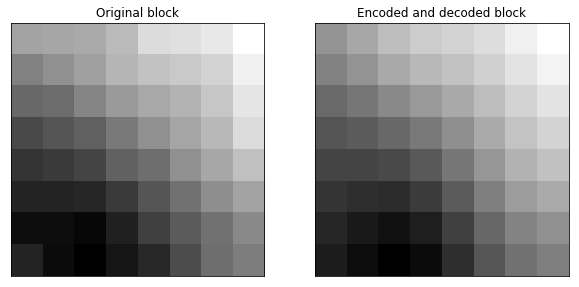

In [133]:
# Encode and decode a single block
dc_bits, ac_bits = encode_block(block, "y", quality=75)
dc_gen = decode_huffman(dc_bits.to01(), "dc", "y")
ac_gen = decode_huffman(ac_bits.to01(), "ac", "y")
block_rec = decode_block(dc_gen, ac_gen, "y", quality=75)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(block, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title("Original block")
plt.subplot(1,2,2)
plt.imshow(block_rec, cmap='gray'), plt.xticks([]), plt.yticks([])
plt.title("Encoded and decoded block")
plt.show()

**Question:** In the given Huffman coding example with four unique symbols, $\{a, b, c, d\}$, what would happen if all four symbols occured with equal probability? How much compression would we achieve on average using the given Huffman code?

**Answer:** If all 4 symbols occur with equal probability, then on average you lose out on compression. Compared to 2 bits per symbol (00, 01, 10, 11), you save 1 bit per $a$ and lose 1 bit each for $c$ and $d$, for $-1$ bits saved on average.

### Task VI: Compression ratio

Let's put it all together! This code iterates on all the blocks in an image and encodes the various components into bitarrays. First, we need a function to pad the image rows and columns to the next multiple of 16 (remember that each chroma block represents 16x16 pixels in the original image). We use _symmetric padding_ to try to add as little energy as possible to the DCT coefficients of the padded blocks.

In [111]:
def mirror_pad(img):
    # Input:  a 3D float array, img, representing an RGB image in range [0.0,255.0]
    # Output: a 3D float array, img_pad, mirror padded so the number of rows and columns are multiples of 16
    
    M, N = img.shape[0:2]
    pad_r = ((16 - (M % 16)) % 16) # number of rows to pad
    pad_c = ((16 - (N % 16)) % 16) # number of columns to pad
    img_pad = np.pad(img, ((0,pad_r), (0,pad_c), (0,0)), "symmetric") # symmetric padding
    
    return img_pad

In [112]:
def encode_image(img, quality=75):
    # Inputs:  a 3D float array, img, representing an RGB image in range [0.0,255.0]
    #          an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Outputs: a bitarray, Y_dc_bits, the Y component DC bitstream
    #          a bitarray, Y_ac_bits, the Y component AC bitstream
    #          a bitarray, Cb_dc_bits, the Cb component DC bitstream
    #          a bitarray, Cb_ac_bits, the Cb component AC bitstream
    #          a bitarray, Cr_dc_bits, the Cr component DC bitstream
    #          a bitarray, Cr_ac_bits, the Cr component AC bitstream
    
    M_orig, N_orig = img.shape[0:2]
    img = mirror_pad(img[:,:,0:3])
    M, N = img.shape[0:2]
    
    im_ycbcr = RGB2YCbCr(img)    
    Y = im_ycbcr[:,:,0]
    Cb = chroma_downsample(im_ycbcr[:,:,1])
    Cr = chroma_downsample(im_ycbcr[:,:,2])
    
    # Y component
    Y_dc_bits = bitarray()
    Y_ac_bits = bitarray()
    for i in np.r_[0:M:8]:
        for j in np.r_[0:N:8]:
            block = Y[i:i+8,j:j+8]
            dc_bits, ac_bits = encode_block(block, "y", quality)
            Y_dc_bits.extend(dc_bits)
            Y_ac_bits.extend(ac_bits)
    
    # Cb component
    Cb_dc_bits = bitarray()
    Cb_ac_bits = bitarray()
    for i in np.r_[0:M//2:8]:
        for j in np.r_[0:N//2:8]:
            block = Cb[i:i+8,j:j+8]
            dc_bits, ac_bits = encode_block(block, "c", quality)
            Cb_dc_bits.extend(dc_bits)
            Cb_ac_bits.extend(ac_bits)
            
    # Cr component
    Cr_dc_bits = bitarray()
    Cr_ac_bits = bitarray()
    for i in np.r_[0:M//2:8]:
        for j in np.r_[0:N//2:8]:
            block = Cr[i:i+8,j:j+8]
            dc_bits, ac_bits = encode_block(block, "c", quality)
            Cr_dc_bits.extend(dc_bits)
            Cr_ac_bits.extend(ac_bits)
            
    bits = (Y_dc_bits, Y_ac_bits, Cb_dc_bits, Cb_ac_bits, Cr_dc_bits, Cr_ac_bits)
    
    return bits

In [119]:
def decode_image(bits, M, N, quality=75):
    # Inputs: a tuple, bits, containing the following:
    #              a bitarray, Y_dc_bits, the Y component DC bitstream
    #              a bitarray, Y_ac_bits, the Y component AC bitstream
    #              a bitarray, Cb_dc_bits, the Cb component DC bitstream
    #              a bitarray, Cb_ac_bits, the Cb component AC bitstream
    #              a bitarray, Cr_dc_bits, the Cr component DC bitstream
    #              a bitarray, Cr_ac_bits, the Cr component AC bitstream
    #         ints, M and N, the number of rows and columns in the image
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    # Output: a 3D float array, img, representing an RGB image in range [0.0,255.0]
    
    Y_dc_bits, Y_ac_bits, Cb_dc_bits, Cb_ac_bits, Cr_dc_bits, Cr_ac_bits = bits # unpack bits tuple
    
    M_orig = M # save original image dimensions
    N_orig = N
    M = M_orig + ((16 - (M_orig % 16)) % 16) # dimensions of padded image
    N = N_orig + ((16 - (N_orig % 16)) % 16)
    num_blocks = M * N // 64 # number of blocks
    
    # Y component
    Y_dc_gen = decode_huffman(Y_dc_bits.to01(), "dc", "y")
    Y_ac_gen = decode_huffman(Y_ac_bits.to01(), "ac", "y")
    Y = np.empty((M, N))
    for b in range(num_blocks):
        block = decode_block(Y_dc_gen, Y_ac_gen, "y", quality)
        r = (b*8 // N)*8 # row index (top left corner)
        c = b*8 % N # column index (top left corner)
        Y[r:r+8, c:c+8] = block

    # Cb component
    Cb_dc_gen = decode_huffman(Cb_dc_bits.to01(), "dc", "c")
    Cb_ac_gen = decode_huffman(Cb_ac_bits.to01(), "ac", "c")
    Cb2 = np.empty((M//2, N//2))
    for b in range(num_blocks//4):
        block = decode_block(Cb_dc_gen, Cb_ac_gen, "c", quality)
        r = (b*8 // (N//2))*8 # row index (top left corner)
        c = b*8 % (N//2) # column index (top left corner)
        Cb2[r:r+8, c:c+8] = block

    # Cr component
    Cr_dc_gen = decode_huffman(Cr_dc_bits.to01(), "dc", "c")
    Cr_ac_gen = decode_huffman(Cr_ac_bits.to01(), "ac", "c")
    Cr2 = np.empty((M//2, N//2))
    for b in range(num_blocks//4):
        block = decode_block(Cr_dc_gen, Cr_ac_gen, "c", quality)
        r = (b*8 // (N//2))*8 # row index (top left corner)
        c = b*8 % (N//2) # column index (top left corner)
        Cr2[r:r+8, c:c+8] = block

    Cb = chroma_upsample(Cb2)
    Cr = chroma_upsample(Cr2)

    img = YCbCr2RGB(np.stack((Y,Cb,Cr), axis=-1))
    
    img = img[0:M_orig,0:N_orig,:] # crop out padded parts

    return img

We are now ready to encode an image and decode!


In [142]:
bits = encode_image(img, quality=75)
img_dec = decode_image(bits, M, N, quality=75)

Let's calculate the number of bits per pixel in the compressed image. Note how much information is required for each component.

In [143]:
# print average bits per pixel for each component
num_bits = [len(b) for b in bits]
num_pix = M * N
print("Y DC:  {:0.3f} bit/pix".format(num_bits[0] / num_pix))
print("Y AC:  {:0.3f} bit/pix".format(num_bits[1] / num_pix))
print("Cb DC: {:0.3f} bit/pix".format(num_bits[2] / num_pix))
print("Cb AC: {:0.3f} bit/pix".format(num_bits[3] / num_pix))
print("Cr DC: {:0.3f} bit/pix".format(num_bits[4] / num_pix))
print("Cr AC: {:0.3f} bit/pix".format(num_bits[5] / num_pix))
print("Total: {:0.3f} bit/pix".format(np.sum(num_bits) / num_pix))

# print compression ratio
print("Compression ratio: {:0.2f}".format(24 * num_pix / np.sum(num_bits)))

Y DC:  0.132 bit/pix
Y AC:  1.022 bit/pix
Cb DC: 0.033 bit/pix
Cb AC: 0.054 bit/pix
Cr DC: 0.034 bit/pix
Cr AC: 0.047 bit/pix
Total: 1.322 bit/pix
Compression ratio: 18.15


Now, display the original image next to the compressed. Also display an error image, scaled by a factor of 10 (so you can see the difference!).

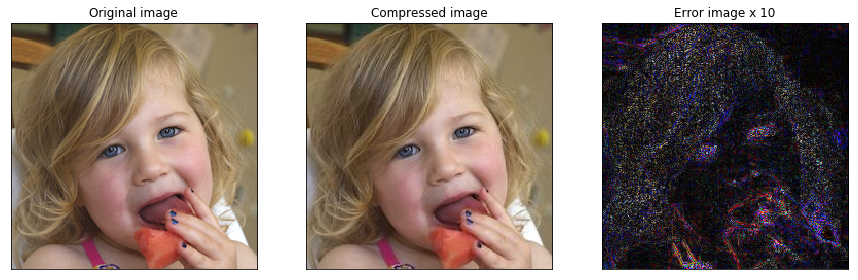

In [144]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.title("Original image")
plt.subplot(1,3,2)
plt.imshow(img_dec.astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title("Compressed image")
plt.subplot(1,3,3)
plt.imshow(abs((img_dec - img.astype(float))*10).astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title("Error image x 10")
plt.show()

**Question:** The original uncompressed image used 24 bits (8 per color channel) to represent each pixel. After following all the compression steps using a quality factor of 75, how many bits per pixel does your compressed image use? What compression ratio do you achieve?

**Answer:** 1.322 bits / pixel with a compression ratio of 18.15

### Task VII: The JPEG123 file format

We now have the ability to encode a single block of one image component into a bitstream, but how can we encode an entire image into a single file? We not only need the bits encoding the image information, but we also need metadata, including the image dimensions, the number of color channels, the DCT block size, the amount of chroma downsampling, the quantization tables used, the quality factor, the Huffman table useds, etc. For the purposes of this lab, we will be writing a file that includes the minimum amount of information required to decode our image: the image dimensions and the quality factor. All the other metadata values will be assumed to be fixed (e.g. RGB color channels, 8x8 DCT, 2x2 chroma downsampling, baseline luma and chroma quantization tables, baseline Huffman tables).

The file format will be as follows (0x means hexadecimal notation):
1. Start of Image (SOI) marker - 0xFFD8 (2 bytes)
2. Number of rows - unsigned int (2 bytes)
3. Number of columns - unsigned int (2 bytes)
4. Quality factor - unsigned int (2 bytes)
5. Start of Scan (SOS) - 0xFFDA (2 bytes)
6. Y component DC values - (? bytes)
7. Start of Scan (SOS) - 0xFFDA (2 bytes)
8. Y component AC values - (? bytes)
9. Start of Scan (SOS) - 0xFFDA (2 bytes)
10. Cb component DC values - (? bytes)
11. Start of Scan (SOS) - 0xFFDA (2 bytes)
12. Cb component AC values - (? bytes)
13. Start of Scan (SOS) - 0xFFDA (2 bytes)
14. Cr component DC values - (? bytes)
15. Start of Scan (SOS) - 0xFFDA (2 bytes)
16. Cr component AC values - (? bytes)
17. End of Image (EOI) marker - 0xFFD9 (2 bytes)

Note that this format would be called non-progressive and non-interleaved. Interleaved means that the luma and chroma component data are interleaved together instead of occuring in separate chunks, and progressive means lower resolution information (e.g. just the DC values) occurs earlier in the file, so the decoder can begin reconstructing a lower quality image even before all the bits arrive. This is useful for low-bandwidth applications or slow hardware.

Write a function, which takes a numpy uint8 color RGB image array, a file name to output (file extention .jpeg123), and a quality factor. The function will compress the image array into our JPEG-like format and store it in the file. Some functions you may like to know about are `bytes.fromhex()`, `(int).to_bytes()`, `open()`, `(file).write()`, and `bitarray.tofile()`. **Note:** to be compatible with our decoder, please pad your bitarrays to be an even number of bytes (the length of each bitarray you write to the file must be a multiple of 16). You can do this by concatenating the appropriate number of '1' bits to the end of each bitarray. **Hint:** the appropriate number is `(16 - (len(bitarr) % 16)) % 16`.

In [181]:
def jpeg123_encoder(img, outfile, quality=75):
    # Inputs: a 3D uint8 array, img, representing an RGB color image
    #         a string, outfile, of the output binary filename
    #         an int, quality, the JPEG quality factor in range [1,100] (defaults to 75)
    
    img = img.astype(np.float64)
    M, N = img.shape[0:2]
    
    bits = encode_image(img, quality=quality)

    with open(outfile, "wb") as fh:
        # Your code here        
        SOI = bitarray(endian='big')
        SOI.frombytes(bytes.fromhex("FFD8"))
        SOS = bitarray(endian='big')
        SOS.frombytes(bytes.fromhex("FFDA"))
        EOI = bitarray(endian='big')
        EOI.frombytes(bytes.fromhex("FFD9"))
        
        #bitarray(bytes, endian='big') big by default
        SOI.tofile(fh)
        #rows
        rows = bitarray(endian='big')
        rows.frombytes(M.to_bytes(2, 'big'))
        rows.tofile(fh)
        #columns
        cols = bitarray(endian='big')
        cols.frombytes(N.to_bytes(2, 'big'))
        cols.tofile(fh)
        #quality factor
        q_fact = bitarray(endian='big')
        q_fact.frombytes(quality.to_bytes(2, 'big'))
        q_fact.tofile(fh)
        #in bits: index 0 = Y DC, 1 = Y AC, 2 = Cb DC, 3 = Cb AC, 4 = Cr DC, 5 = Cr AC
        for bitarr in bits:
            SOS.tofile(fh)
            bitarr.extend(bitarray([1]*((16 - (len(bitarr) % 16)) % 16), endian='big'))
            bitarr.tofile(fh)
        EOI.tofile(fh)
        

We have provided the decoder for you, implemented below. The encoder you implement should be compatible with our decoder.

In [146]:
def jpeg123_decoder(infile):
    # Inputs:  a string, infile, of the input binary filename
    # Outputs: a 3D uint8 array, img_dec, representing a decoded JPEG123 color image
    
    with open(infile, "rb") as fh:
        SOI = fh.read(2)
        if SOI != bytes.fromhex("FFD8"):
            raise Exception("Start of Image marker not found!")
        M = int.from_bytes(fh.read(2), "big")
        N = int.from_bytes(fh.read(2), "big")
        quality = int.from_bytes(fh.read(2), "big")
        SOS = fh.read(2)
        if SOS != bytes.fromhex("FFDA"):
            raise Exception("Start of Scan marker not found!")
        bits = ()
        for _ in range(5):
            ba = bitarray()
            for b in iter(lambda: fh.read(2), bytes.fromhex("FFDA")): # iterate until next SOS marker
                ba.frombytes(b)
            bits = (*bits, ba)
        ba = bitarray()
        for b in iter(lambda: fh.read(2), bytes.fromhex("FFD9")): # iterate until EOI marker
            ba.frombytes(b)
        bits = (*bits, ba)
    
    img_dec = decode_image(bits, M, N, quality)
    
    return img_dec.astype(np.uint8)

Encode the image in a JPEG123 file, and load the file back. Display the image!

In [187]:
img = Image.open("NetaLi_small.tiff")
img = np.array(img)[:,:,0:3]

jpeg123_encoder(img, "NetaLi_small.jpeg123", quality=95)

In [188]:
img_dec = jpeg123_decoder("NetaLi_small.jpeg123")

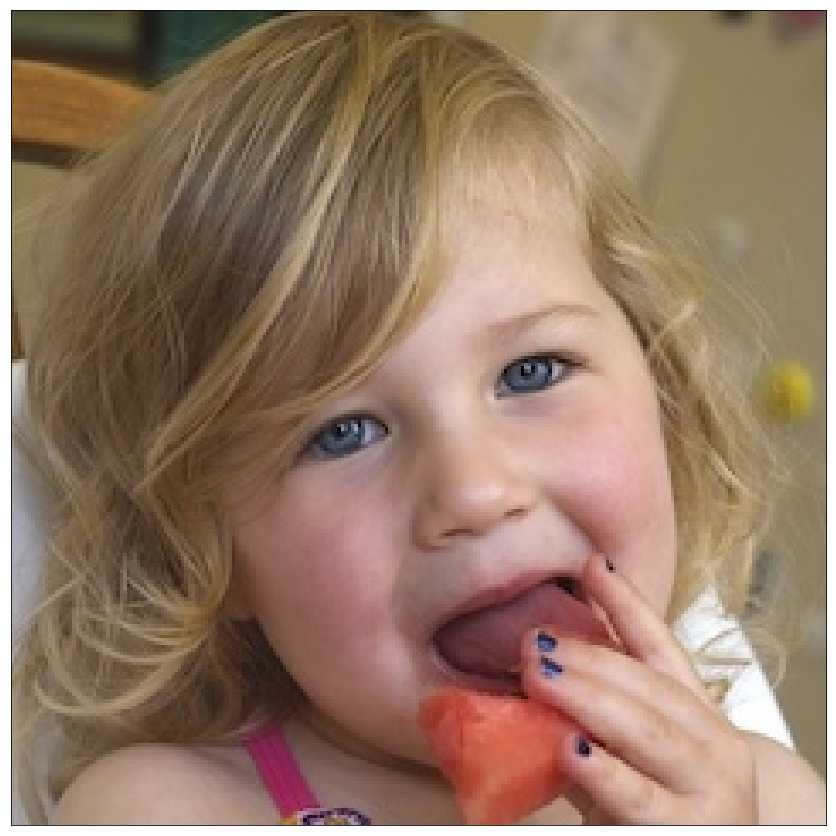

In [189]:
plt.figure(figsize=(15,15))
plt.imshow(img_dec), plt.xticks([]), plt.yticks([])
plt.show()

Calculate the bits-per-pixel (BPP) by reading the size of the file in bytes, and dividing by the number of pixels in the image. What is the total compression ratio (i.e, the size of the original file divided by the size of the compressed file)?

In [190]:
BPP = stat("NetaLi_small.jpeg123").st_size*8 / (img_dec.shape[0]*img_dec.shape[1])
print("The BPP is:", BPP)

The BPP is: 3.2222222222222223


In [191]:
comp_ratio = stat("NetaLi_small.tiff").st_size / stat("NetaLi_small.jpeg123").st_size
print("The compression ratio is:", comp_ratio)

The compression ratio is: 7.554137931034483


Experiment with different quality factors!

### Task VIII: Rate-distortion curve

The standard metric for evaluating the quality of a decoded compressed image $I_{dec}$ is the Peak Signal-to-Noise Ratio (PSNR) with respect to the original reference image $I_{ref}$, and defined as

$$ \text{PSNR}(I_{dec}, I_{ref}) = 10 \log_{10}\left( \frac{255^2}{\text{MSE}(I_{dec},I_{ref})} \right) $$

where MSE is the mean squared error between $I_{dec}$ and $I_{ref}$, defined as

$$ \text{MSE}(I_{dec},I_{ref}) = \frac{1}{3mn} \sum_{i=0}^{m-1} \sum_{j=0}^{n-1} \sum_{k=0}^{2} \left( I_{ref}[i,j,k] - I_{dec}[i,j,k] \right)^2 $$

where i, j, and k index the pixel location and color channel of the image. Write a function that computes the PSNR of a decoded compressed image with respect to the original reference image. **Hint:** don't forget to cast to float before performing the computations!

In [194]:
def compute_psnr(I_dec, I_ref):
    # Input:  an array, I_dec, representing a decoded image in range [0.0,255.0]
    #         an array, I_ref, representing a reference image in range [0.0,255.0]
    # Output: a float, PSNR, representing the PSNR of the decoded image w.r.t. the reference image (in dB)
    
    # Your code here
    #MSE    m=height(0), n=width(1)
    MSE = 0
    for i in range(len(I_dec)):
        for j in range(len(I_dec[0])):
            for k in range(2):
                MSE += (float(I_ref[i][j][k]) - float(I_dec[i][j][k]))**2
    MSE /= float(3*len(I_dec)*len(I_dec[0]))
    
    PSNR = 10 * np.log10(255.0**2 / MSE)
    
    return PSNR

A typical way to evaluate the compression quality of an encoder on a given image is to compute a rate-distortion curve. This measures the PSNR as a function of compression or BPP. Since the quality factor is not linearly correlated with the compression, we will sweep a range of quality factors, compute the resulting BPP and PSNR, and plot PSNR vs. BPP. 

Compute the rate-distortion curve for the above image.

1
5
10
20
30
40
50
60
70
80
90
95
100


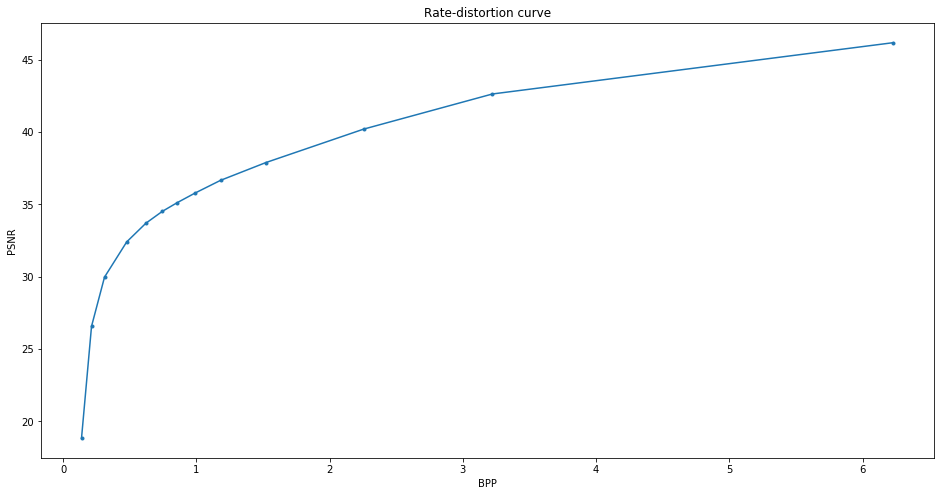

In [195]:
# compute rate-distortion curve for JPEG123 image codec on the given image
quality = [1,5,10,20,30,40,50,60,70,80,90,95,100]
bpp = []
psnr = []

img = Image.open("NetaLi_small.tiff")
img = np.array(img)[:,:,0:3]
file_enc = "tmp.jpeg123"
img_ref = img.copy()

for q in quality:
    print(q)
    jpeg123_encoder(img_ref, file_enc, quality=q)
    sz = stat(file_enc).st_size
    img_dec = jpeg123_decoder(file_enc)
    M, N = img_dec.shape[:2]
    b = sz*8 / (M * N)
    p = compute_psnr(img_dec, img_ref)
    bpp.append(b)
    psnr.append(p)
bpp = np.array(bpp)
psnr = np.array(psnr)

plt.figure(figsize=(16,8))
plt.plot(bpp, psnr, '.-')
plt.title("Rate-distortion curve")
plt.xlabel('BPP')
plt.ylabel('PSNR')
plt.show()

Now, compute the rate-distortion curve for standard JPEG using the PIL library. Compute it both with and without building optimized Huffman codes by adding the optional keyword argument `optimize` to `Image.save()`. Plot our rate and the two PIL library rates on the same graph.
Who's better? How can it be?

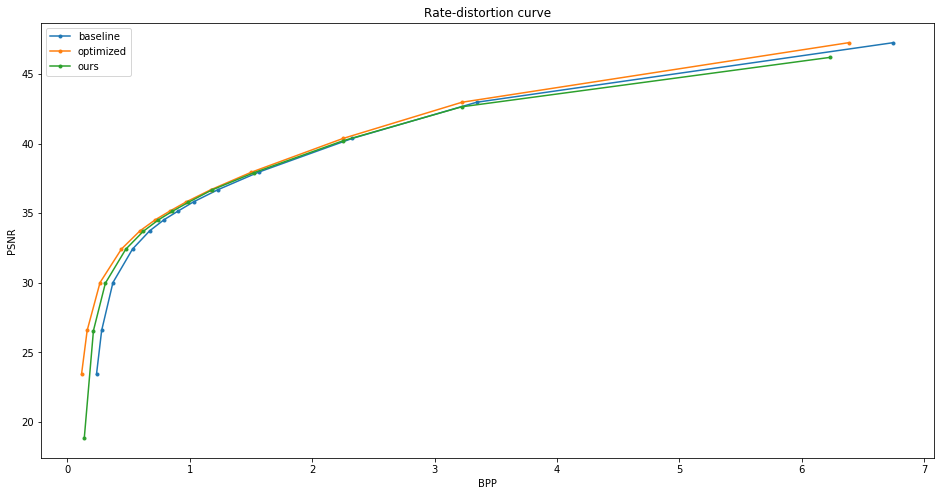

In [196]:
# compute rate-distortion curve for baseline JPEG on the given image
quality = [1,5,10,20,30,40,50,60,70,80,90,95,100]
bpp_base = []
psnr_base = []
bpp_opt = []
psnr_opt = []

img = Image.open("NetaLi_small.tiff")
img = np.array(img)[:,:,0:3]
file_enc = "tmp.jpg"
img_ref = img.copy()
im = Image.fromarray(img_ref)

for q in quality:
#     print(q)
    im.save(file_enc, 'jpeg', quality=q, optimize=False)
    sz = stat(file_enc).st_size
    img_dec = Image.open(file_enc)
    img_dec = np.array(img_dec)[:,:,0:3]
    M, N = img_dec.shape[:2]
    b = sz*8 / (M * N)
    p = compute_psnr(img_dec, img_ref)
    bpp_base.append(b)
    psnr_base.append(p)
    
    im.save(file_enc, 'jpeg', quality=q, optimize=True)
    sz = stat(file_enc).st_size
    img_dec = Image.open(file_enc)
    img_dec = np.array(img_dec)[:,:,0:3]
    M, N = img_dec.shape[:2]
    b = sz*8 / (M * N)
    p = compute_psnr(img_dec, img_ref)
    bpp_opt.append(b)
    psnr_opt.append(p)
    
bpp_base = np.array(bpp_base)
psnr_base = np.array(psnr_base)
bpp_opt = np.array(bpp_opt)
psnr_opt = np.array(psnr_opt)

plt.figure(figsize=(16,8))
plt.plot(bpp_base, psnr_base, '.-', bpp_opt, psnr_opt, '.-', bpp, psnr, '.-')
plt.title("Rate-distortion curve")
plt.xlabel("BPP")
plt.ylabel("PSNR")
plt.legend(("baseline", "optimized", "ours"))
plt.show()

**Question:** How do the different methods compare in the high compression regime (less than 1 bit-per-pixel)? How can you explain this?

**Answer:** Our implementation of compression at high BPP has a worse PSNR (more noise) than the other methods at a similar BPP. This could be explained by different Huffman encoding which would result in different zero runs and thus possible better compression.

### Task IX: Get creative

Try encoding and decoding some other images at different quality factors and computing rate-distortion curves to see how they compare to the example image used above. We have included some extra images with this lab notebook, but please feel free to add your own images! Try to find lossless images (definitely don't use JPEGs...). PNGs are a common lossless image format, but if a PNG was a JPEG in the past, then the damage has already been done.

At different quality factors, examine the 10x amplified error image. Where do errors typically show up in the compressed image? What can the rate-distortion curve tell you about which images are easier or harder to compress?

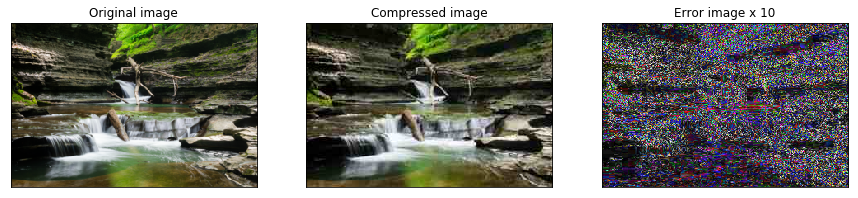

In [197]:
# filename = "text.png"
# filename = "glass.png"
# filename = "optics.png"
filename = "creek.png"

img = Image.open(filename)
img = np.array(img)[:,:,0:3]

jpeg123_encoder(img, "tmp.jpeg123", quality=25)
img_dec = jpeg123_decoder("tmp.jpeg123")

# Plots
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.title("Original image")
plt.subplot(1,3,2)
plt.imshow(img_dec.astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title("Compressed image")
plt.subplot(1,3,3)
plt.imshow(abs((img_dec - img.astype(float))*10).astype(np.uint8)), plt.xticks([]), plt.yticks([])
plt.title("Error image x 10")
plt.show()

1
5
10
20
30
40
50
60
70
80
90
95
100


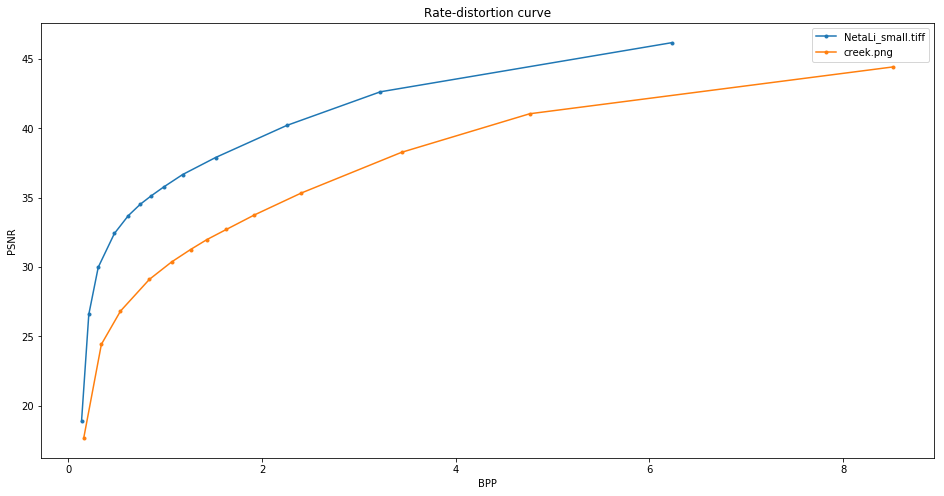

In [198]:
# compute rate-distortion curve for JPEG123 image codec on the given image
quality = [1,5,10,20,30,40,50,60,70,80,90,95,100]
bpp_new = []
psnr_new = []

img_ref = Image.open(filename)
img_ref = np.array(img)[:,:,0:3]

file_enc = "tmp.jpeg123"

for q in quality:
    print(q)
    jpeg123_encoder(img_ref, file_enc, quality=q)
    sz = stat(file_enc).st_size
    img_dec = jpeg123_decoder(file_enc)
    M, N = img_dec.shape[:2]
    b = sz*8 / (M * N)
    p = compute_psnr(img_dec, img_ref)
    bpp_new.append(b)
    psnr_new.append(p)
bpp_new = np.array(bpp_new)
psnr_new = np.array(psnr_new)

plt.figure(figsize=(16,8))
plt.plot(bpp, psnr, '.-', bpp_new, psnr_new, '.-')
plt.title("Rate-distortion curve")
plt.xlabel('BPP')
plt.ylabel('PSNR')
plt.legend(("NetaLi_small.tiff", filename))
plt.show()